In [1]:
%load_ext autoreload
%autoreload 2

import logging
from dotenv import load_dotenv

logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)

In [2]:
import pandas as pd
from projects.pltv.feature_engineering import clean_df
from projects.pltv.objects import Level

level = Level(group_bys=["brand", "sku_type", "channel"])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_parquet("output_dataset.parquet")
clean_df(df)

for col in df.columns:
    print(col)
df.head()

START_DATE_MONTH
BRAND
SKU_TYPE
CHANNEL
PLAN__IS_PROMO
GROSS_ADDS_CREATED_OVER_1_DAYS_AGO
GROSS_ADDS_CREATED_OVER_3_DAYS_AGO
GROSS_ADDS_CREATED_OVER_7_DAYS_AGO
GROSS_ADDS_CREATED_OVER_30_DAYS_AGO
GROSS_ADDS_CREATED_OVER_60_DAYS_AGO
GROSS_ADDS_CREATED_OVER_90_DAYS_AGO
GROSS_ADDS_CREATED_OVER_180_DAYS_AGO
GROSS_ADDS_CREATED_OVER_365_DAYS_AGO
GROSS_ADDS_CREATED_OVER_730_DAYS_AGO
GROSS_ADDS
GROSS_ADDS_CANCELED_DAY_ONE
GROSS_ADDS_CANCELED_DAY_ONE_RATE
GROSS_ADDS_CANCELED_DAY_THREE
GROSS_ADDS_CANCELED_DAY_THREE_RATE
GROSS_ADDS_CANCELED_DAY_SEVEN
GROSS_ADDS_CANCELED_DAY_SEVEN_RATE
AVG_PROMO_DAYS
AVG_PROMO_PRICE
AVG_RECURRING_DAYS
AVG_RECURRING_PRICE
PROMO_TO_RECURRING_DAYS_RATIO
PROMO_TO_RECURRING_PRICE_RATIO
ELIGIBLE_PROMO_ACTIVATIONS
ELIGIBLE_FIRST_REBILLS
PROMO_ACTIVATION_RATE
FIRST_REBILL_RATE
AVG_NET_BILLINGS_30_DAYS
AVG_NET_BILLINGS_60_DAYS
AVG_NET_BILLINGS_90_DAYS
AVG_NET_BILLINGS_180_DAYS
AVG_NET_BILLINGS_365_DAYS
AVG_NET_BILLINGS_730_DAYS


,START_DATE_MONTH,BRAND,SKU_TYPE,CHANNEL,PLAN__IS_PROMO,GROSS_ADDS_CREATED_OVER_1_DAYS_AGO,GROSS_ADDS_CREATED_OVER_3_DAYS_AGO,GROSS_ADDS_CREATED_OVER_7_DAYS_AGO,GROSS_ADDS_CREATED_OVER_30_DAYS_AGO,GROSS_ADDS_CREATED_OVER_60_DAYS_AGO,GROSS_ADDS_CREATED_OVER_90_DAYS_AGO,GROSS_ADDS_CREATED_OVER_180_DAYS_AGO,GROSS_ADDS_CREATED_OVER_365_DAYS_AGO,GROSS_ADDS_CREATED_OVER_730_DAYS_AGO,GROSS_ADDS,GROSS_ADDS_CANCELED_DAY_ONE,GROSS_ADDS_CANCELED_DAY_ONE_RATE,GROSS_ADDS_CANCELED_DAY_THREE,GROSS_ADDS_CANCELED_DAY_THREE_RATE,GROSS_ADDS_CANCELED_DAY_SEVEN,GROSS_ADDS_CANCELED_DAY_SEVEN_RATE,AVG_PROMO_DAYS,AVG_PROMO_PRICE,AVG_RECURRING_DAYS,AVG_RECURRING_PRICE,PROMO_TO_RECURRING_DAYS_RATIO,PROMO_TO_RECURRING_PRICE_RATIO,ELIGIBLE_PROMO_ACTIVATIONS,ELIGIBLE_FIRST_REBILLS,PROMO_ACTIVATION_RATE,FIRST_REBILL_RATE,AVG_NET_BILLINGS_30_DAYS,AVG_NET_BILLINGS_60_DAYS,AVG_NET_BILLINGS_90_DAYS,AVG_NET_BILLINGS_180_DAYS,AVG_NET_BILLINGS_365_DAYS,AVG_NET_BILLINGS_730_DAYS
0,2025-04-01,InstantCheckmate,Background,MediaDisplay,True,18,18,18,18,18,18,18,0,0,18,4,0.222222,5,0.277778,6,0.333333,11.944444,4.538889,30.000000,35.470001,0.398148,0.127964,18.0,12.0,0.166667,NaN,9.922223,11.837223,11.837223,11.837223,NaN,NaN
1,2022-08-01,Intelius,ReversePhoneLookup,Seo,False,18,18,18,18,18,18,18,18,18,18,1,0.055556,2,0.111111,2,0.111111,NaN,NaN,30.000000,4.990000,NaN,NaN,NaN,20.0,NaN,0.650000,8.861111,9.415555,11.910556,16.900555,21.890555,28.543888
2,2022-05-01,Intelius,Background,MediaDisplay,False,18,18,18,18,18,18,18,18,18,18,5,0.277778,5,0.277778,5,0.277778,NaN,NaN,33.333332,26.792223,NaN,NaN,NaN,22.0,NaN,0.545455,40.331665,43.233890,53.456112,81.360555,117.828885,137.728895
3,2025-07-01,OmniWatch,BasicMonthly,PaidSearch,False,18,18,18,18,18,18,0,0,0,18,0,0.000000,0,0.000000,2,0.111111,NaN,NaN,30.000000,10.000000,NaN,NaN,NaN,18.0,NaN,0.555556,9.444444,15.555556,20.555556,NaN,NaN,NaN
4,2023-08-01,InstantCheckmate,ReversePhoneLookup,EngagementEmail,True,18,18,18,18,18,18,18,18,18,18,4,0.222222,5,0.277778,8,0.444444,5.000000,1.990000,30.000000,6.990000,0.166667,0.284692,19.0,16.0,0.315789,0.250000,10.864444,13.592222,13.981111,15.924445,18.646111,20.201667


In [3]:
from typing import cast

from projects.pltv import config
from src.pipeline.xgboost import get_pipeline, prepare_data


def run_pipeline(train_df: pd.DataFrame, predict_df: pd.DataFrame):
    logger.info(f"Running model on {len(df)} rows")

    cat_cols = level.get_all_cat_cols(config.cat_cols)
    num_cols = config.num_cols
    target_col = 'AVG_NET_BILLINGS_30_DAYS'


    # Create pipeline
    model, preprocessor = get_pipeline(
        cat_cols=cat_cols,
        num_cols=num_cols,
    )

    # Prepare training data
    train_prepared = prepare_data(
        df=train_df,
        target_col=target_col,
        preprocessor=preprocessor,
        fit_preprocessor=True,
    )

    # Extract X and y for training
    X_train = train_prepared.drop(columns=['y'])
    y_train: pd.Series = train_prepared['y']  # type: ignore

    # Fit the model
    logger.info(f"Training on {len(X_train)} samples...")
    model.fit(X_train, y_train)

    # Prepare prediction data
    logger.info("Preparing prediction data...")
    predict_prepared = prepare_data(
        df=predict_df,
        target_col=target_col,
        preprocessor=preprocessor,
        fit_preprocessor=False,
    )

    # Make predictions with intervals
    X_predict = predict_prepared.drop(columns=['y'], errors='ignore')
    predictions = model.predict_with_intervals(X_predict)  # type: ignore

    result_df = predict_df.reset_index(drop=True).copy()
    predictions_aligned = predictions.reset_index(drop=True)
    
    # Add only the prediction columns (no modifications to existing columns)
    result_df['PRED_Y'] = predictions_aligned['yhat'].values
    result_df['PRED_Y_LOWER'] = predictions_aligned['yhat_lower'].values
    result_df['PRED_Y_UPPER'] = predictions_aligned['yhat_upper'].values
    
    logger.info(f"Result dataframe now has {len(result_df.columns)} columns (added 3 prediction columns)")
    logger.info("Pipeline complete!")
    logger.info(f"Prediction statistics:")
    logger.info(f"  Mean predicted value: {result_df['PRED_Y'].mean():.2f}")
    logger.info(f"  Median predicted value: {result_df['PRED_Y'].median():.2f}")
    logger.info(f"  Min predicted value: {result_df['PRED_Y'].min():.2f}")
    logger.info(f"  Max predicted value: {result_df['PRED_Y'].max():.2f}")

    return result_df[[target_col, 'PRED_Y', 'PRED_Y_LOWER', 'PRED_Y_UPPER']], model
    

if config.partition:
    for partition_value in config.partition.values:
        # partition the data
        logger.info(f"Partitioning data where {config.partition.name} = {partition_value}")
        partition_df = df[df[config.partition.name] == partition_value]

        # TODO - loop thru model steps

        # create training criteria
        training_criteria = (
            (df['ELIGIBLE_FIRST_REBILLS'] >= 250)
            & (df['GROSS_ADDS_CREATED_OVER_30_DAYS_AGO'] >= 250)
        )
        train_df_all = partition_df[training_criteria]
        # predict_df = partition_df[~training_criteria]

        from sklearn.model_selection import train_test_split

        train_df, test_df = train_test_split(
            train_df_all,
            test_size=0.1,
            random_state=42
        )
        logger.info(f"Training on {len(train_df)} rows and testing on {len(test_df)} rows")

        result_df, trained_model = run_pipeline(
            cast(pd.DataFrame, train_df), 
            cast(pd.DataFrame, test_df)
        )

        break
else:
    # run_model(df)
    pass

result_df.head()

INFO:__main__:Partitioning data where PLAN__IS_PROMO = True
/var/folders/s2/3h6nwwlx26v_xwq1nzh7372c0000gn/T/ipykernel_37734/2088381193.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df_all = partition_df[training_criteria]
INFO:__main__:Training on 1172 rows and testing on 131 rows
INFO:__main__:Running model on 8843 rows
INFO:src.pipeline.xgboost:Pipeline created for 3 categorical + 11 numerical features
INFO:__main__:Training on 1172 samples...
INFO:src.pipeline.xgboost:Fitting XGBoostRegressor with 1172 samples, 30 features
INFO:src.pipeline.xgboost:Fitting XGBoost model...
INFO:src.pipeline.xgboost:XGBoost model fitted successfully!
INFO:src.pipeline.xgboost:Training RMSE: 0.2133
INFO:__main__:Preparing prediction data...
INFO:__main__:Result dataframe now has 40 columns (added 3 prediction columns)
INFO:__main__:Pipeline complete!
INFO:__main__:Prediction statistics:
INFO:__main__:  Mean predicted value: 13.32
INFO:__main__:  Median pre

,AVG_NET_BILLINGS_30_DAYS,PRED_Y,PRED_Y_LOWER,PRED_Y_UPPER
0,22.832736,23.023911,22.605755,23.442066
1,12.022246,12.168839,11.750683,12.586994
2,12.151384,11.931870,11.513714,12.350025
3,8.312207,9.052671,8.634516,9.470827
4,10.230620,10.201295,9.783139,10.619451


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(y_true: pd.Series, y_pred: pd.Series):
    """Calculate the metrics for actual vs predicted"""
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    # Avoid division by zero and handle edge case of all zeros
    mask = y_true != 0
    if np.sum(mask) > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan  # All true values are zero
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2
    }


evaluate_model(result_df['AVG_NET_BILLINGS_30_DAYS'], result_df['PRED_Y'])

{'rmse': 0.7496580967321591,
 'mae': 0.5083010247522511,
 'mape': 4.031738816283329,
 'r2': 0.9796851129800034}


Top 15 Most Important Features:
                                feature  importance
                   num__AVG_PROMO_PRICE  351.410278
    num__PROMO_TO_RECURRING_PRICE_RATIO   51.358723
                    cat__BRAND_Intelius   13.020226
                 cat__BRAND_TruthFinder   12.764054
         cat__CHANNEL_PushNotifications    7.963732
                   cat__CHANNEL_Organic    7.330261
             num__PROMO_ACTIVATION_RATE    7.121968
                    num__AVG_PROMO_DAYS    3.767033
     num__PROMO_TO_RECURRING_DAYS_RATIO    3.161142
               num__AVG_RECURRING_PRICE    2.837885
           cat__CHANNEL_EngagementEmail    2.525495
num__GROSS_ADDS_CANCELED_DAY_SEVEN_RATE    1.790718
num__GROSS_ADDS_CANCELED_DAY_THREE_RATE    1.536687
            cat__BRAND_InstantCheckmate    1.517761
               cat__SKU_TYPE_Background    1.474547


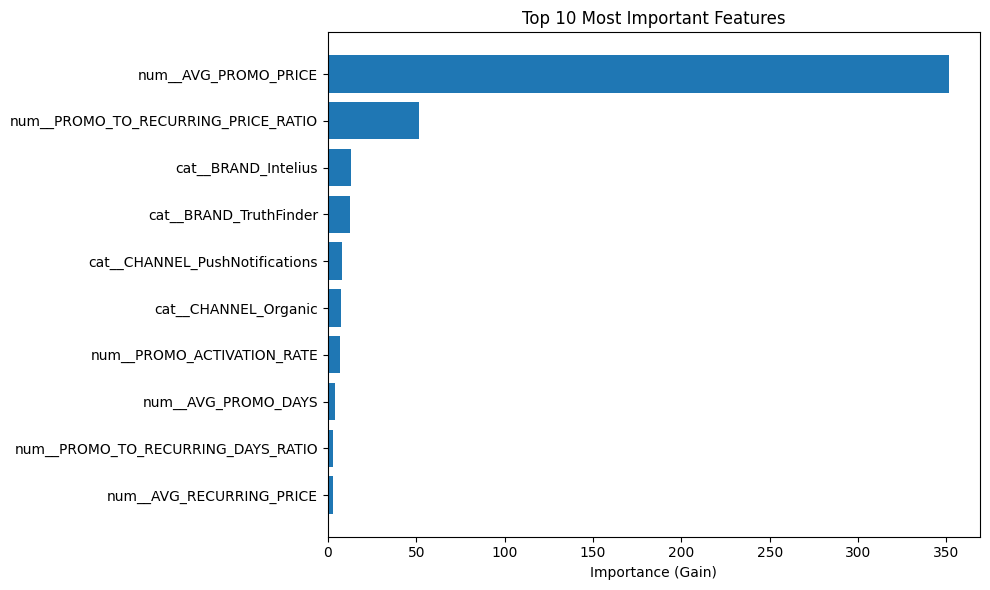